In [1]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 18:24:11--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.97.208, 52.216.86.117, 54.231.139.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.97.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.10MB/s    in 1.8s    

2024-04-07 18:24:13 (7.10 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line = data.split("\n")
header = line[0].split(",")
line = line[1:]
print(header)
print(len(line))

variable_number = len(header)
print("Num variables:", variable_number)
rows_number = len(line)
print("Num rows:", rows_number)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Num variables: 15
Num rows: 420451


In [4]:
import numpy as np
temperature = np.zeros((len(line),))
rawdata = np.zeros((len(line), len(header) - 1))
for i, line in enumerate(line):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    rawdata[i, :] = values[:]

The temperature timeseries plot

Text(0, 0.5, 'Temperature')

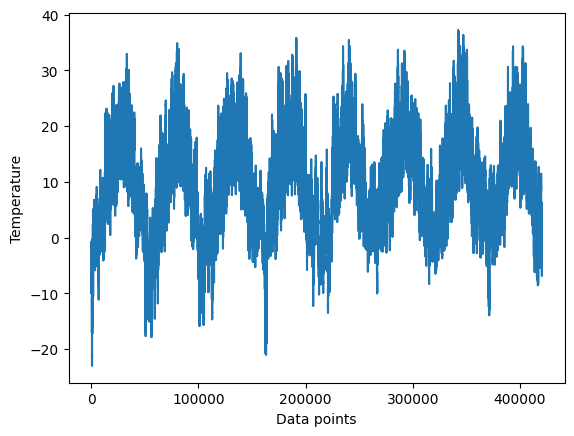

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Text(0, 0.5, 'Temperature')

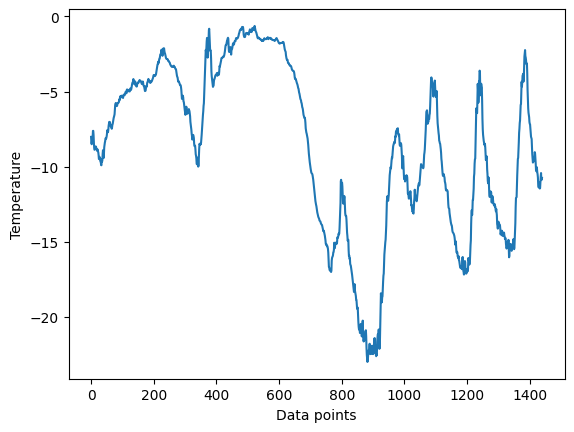

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Figuring out how many samples we'll need for each data split (train = 50%, validation = 25%).

In [7]:
train_values = int(0.5 * len(rawdata))
validation_values= int(0.25 * len(rawdata))
test_values= len(rawdata) - train_values - validation_values
print("Number of train samples:", train_values)
print("Number of validation samples:",validation_values)
print("Number of test samples:", test_values)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Preparing Data


In [8]:
mean = rawdata[:train_values].mean(axis=0)
rawdata -= mean
std = rawdata[:train_values].std(axis=0)
rawdata /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

train_data = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_values)

valid_data = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_values,
    end_index=train_values + validation_values)

test_data = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_values + validation_values)

Generating the output of one of this datasets

In [11]:
for samples, targets in train_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [12]:
def evaluate_naive_method(dataset):
    total_a_e = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_a_e += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_a_e / samples_saw

print(f"Validation MAE: {evaluate_naive_method(valid_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
p1 = layers.Flatten()(inputs)
p1 = layers.Dense(16, activation="relu")(p1)
outputs = layers.Dense(1)(p1)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history1 = model.fit(train_data, epochs=20,
                    validation_data = valid_data, callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 14s 16ms/step - loss: 13.9108 - mae: 2.8890 - val_loss: 11.5667 - val_mae: 2.6999
Epoch 2/20
819/819 [==============================] - 13s 16ms/step - loss: 9.7014 - mae: 2.4597 - val_loss: 10.5090 - val_mae: 2.5639
Epoch 3/20
819/819 [==============================] - 13s 16ms/step - loss: 8.8932 - mae: 2.3545 - val_loss: 10.5274 - val_mae: 2.5581
Epoch 4/20
819/819 [==============================] - 13s 16ms/step - loss: 8.3007 - mae: 2.2756 - val_loss: 10.4518 - val_mae: 2.5704
Epoch 5/20
819/819 [==============================] - 13s 16ms/step - loss: 7.8460 - mae: 2.2153 - val_loss: 10.7674 - val_mae: 2.5954
Epoch 6/20
819/819 [==============================] - 13s 16ms/step - loss: 7.5657 - mae: 2.1760 - val_loss: 11.5050 - val_mae: 2.6956
Epoch 7/20
819/819 [==============================] - 13s 16ms/step - loss: 7.3379 - mae: 2.1436 - val_loss: 11.0301 - val_mae: 2.6308
Epoch 8/20
819/819 [==============================] - 

In [15]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 4s 11ms/step - loss: 11.3405 - mae: 2.6498
Test MAE: 2.65


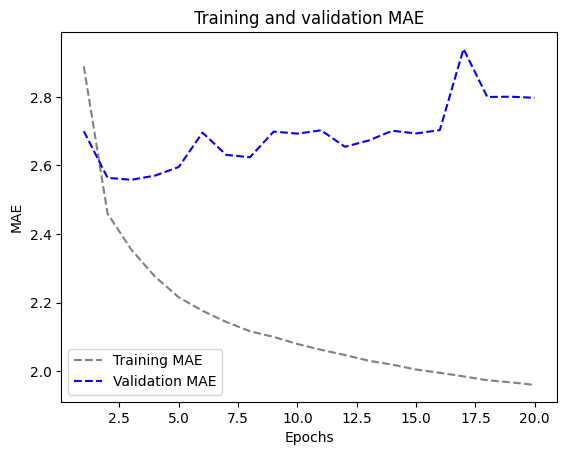

In [16]:
import matplotlib.pyplot as plt
loss = history1.history["mae"]
valid_los = history1.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_los, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
a = layers.Conv1D(8, 24, activation="relu")(inputs)
a = layers.MaxPooling1D(2)(a)
a = layers.Conv1D(8, 12, activation="relu")(a)
a = layers.MaxPooling1D(2)(a)
a = layers.Conv1D(8, 6, activation="relu")(a)
a = layers.GlobalAveragePooling1D()(a)
outputs = layers.Dense(1)(a)
model = keras.Model(inputs, outputs)

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = model.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_data)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 18ms/step - loss: 23.5775 - mae: 3.7984 - val_loss: 15.0016 - val_mae: 3.0653
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.9426 - mae: 3.1725 - val_loss: 16.7408 - val_mae: 3.2286
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.5069 - mae: 3.0286 - val_loss: 19.0156 - val_mae: 3.4740
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.6829 - mae: 2.9348 - val_loss: 14.5768 - val_mae: 2.9844
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 13.0503 - mae: 2.8629 - val_loss: 15.7411 - val_mae: 3.1043
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.4600 - mae: 2.7928 - val_loss: 16.7682 - val_mae: 3.1974
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.8970 - mae: 2.7239 - val_loss: 16.5083 - val_mae: 3.1928
Epoch 8/10
819/819 [============================

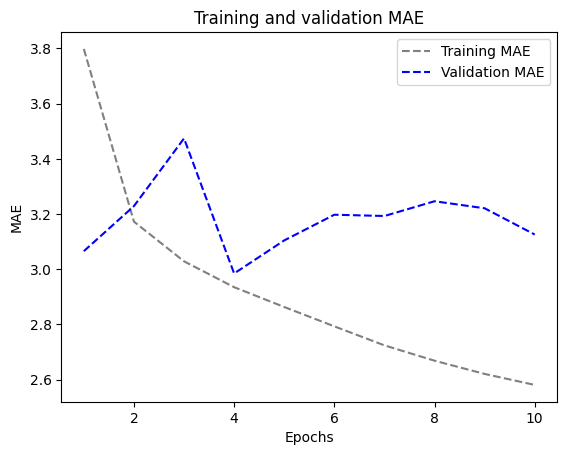

In [ ]:
import matplotlib.pyplot as plt
loss2 = history2.history["mae"]
valid_loss2 = history2.history["val_mae"]

epochs = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs, loss2, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_loss2, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

A Simple RNN

1.An RNN layer that can process sequences of any length

In [ ]:
features = 14
input_of_RNN = keras.Input(shape=(None, features))
output_of_RNN = layers.SimpleRNN(16)(input_of_RNN)

model_of_RNN = keras.Model(input_of_RNN,output_of_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model_of_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_of_RNN = model_of_RNN.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)

model_of_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model_of_RNN.evaluate(test_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 22s 26ms/step - loss: 138.4476 - mae: 9.6956 - val_loss: 144.1889 - val_mae: 9.9218
Epoch 2/5
819/819 [==============================] - 21s 26ms/step - loss: 136.5210 - mae: 9.5748 - val_loss: 143.8106 - val_mae: 9.8825
Epoch 3/5
819/819 [==============================] - 22s 26ms/step - loss: 136.3450 - mae: 9.5582 - val_loss: 143.6708 - val_mae: 9.8690
Epoch 4/5
819/819 [==============================] - 21s 26ms/step - loss: 136.2421 - mae: 9.5481 - val_loss: 143.5883 - val_mae: 9.8564
Epoch 5/5
405/405 [==============================] - 5s 11ms/step - loss: 151.2904 - mae: 9.9203
Test MAE: 9.92


2.Simple RNN - Stacking RNN layers

In [ ]:
features2 = 14
steps = 120
input = keras.Input(shape=(steps, features2))
p2 = layers.SimpleRNN(16, return_sequences=True)(input)
p2 = layers.SimpleRNN(16, return_sequences=True)(p2)
output2 = layers.SimpleRNN(16)(p2)
model2 = keras.Model(input, output2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_of_simple_RNN = model2.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)

model2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model2.evaluate(test_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 65s 76ms/step - loss: 137.2685 - mae: 9.5866 - val_loss: 143.4087 - val_mae: 9.8365
Epoch 2/5
819/819 [==============================] - 62s 75ms/step - loss: 135.9525 - mae: 9.5125 - val_loss: 143.4111 - val_mae: 9.8334
Epoch 3/5
819/819 [==============================] - 62s 75ms/step - loss: 135.9228 - mae: 9.5084 - val_loss: 143.3793 - val_mae: 9.8323
Epoch 4/5
819/819 [==============================] - 62s 76ms/step - loss: 135.8993 - mae: 9.5051 - val_loss: 143.3623 - val_mae: 9.8298
Epoch 5/5
405/405 [==============================] - 10s 23ms/step - loss: 151.0621 - mae: 9.8952
Test MAE: 9.90


A Simple GRU (Gated Recurrent Unit)

In [ ]:
input_of_GRU = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
p3 = layers.GRU(16)(input_of_GRU)
output_of_GRU = layers.Dense(1)(p3)
model_of_GRU = keras.Model(input_of_GRU, output_of_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model_of_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_of_GRU = model_of_GRU.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)

model_of_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model_of_GRU.evaluate(test_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 52s 62ms/step - loss: 46.5048 - mae: 4.9394 - val_loss: 13.4044 - val_mae: 2.7450
Epoch 2/5
819/819 [==============================] - 51s 62ms/step - loss: 10.9415 - mae: 2.5738 - val_loss: 10.4900 - val_mae: 2.4847
Epoch 3/5
819/819 [==============================] - 51s 62ms/step - loss: 9.8243 - mae: 2.4532 - val_loss: 9.5185 - val_mae: 2.3814
Epoch 4/5
819/819 [==============================] - 52s 63ms/step - loss: 9.3663 - mae: 2.3987 - val_loss: 9.7380 - val_mae: 2.3869
Epoch 5/5
405/405 [==============================] - 9s 21ms/step - loss: 9.9590 - mae: 2.4858
Test MAE: 2.49


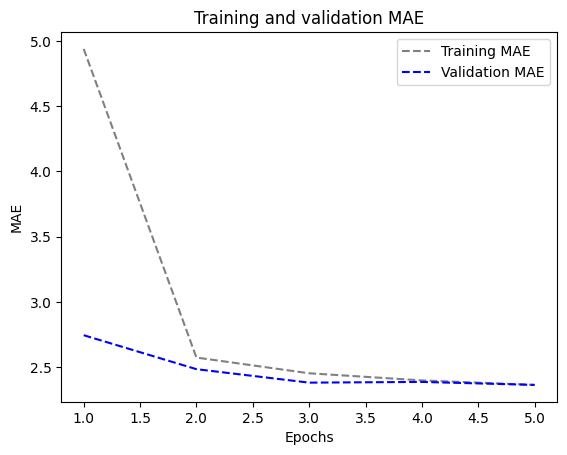

In [ ]:
import matplotlib.pyplot as plt
loss_of_GRU = history_of_GRU.history["mae"]
valid_loss_of_GRU = history_of_GRU.history["val_mae"]

epochs = range(1, len(loss_of_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_of_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_loss_of_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [ ]:
input_of_LSTMS = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
p4 = layers.LSTM(16)(input_of_LSTMS)
output_of_LSTMS = layers.Dense(1)(p4)
model_of_LSTMS = keras.Model(input_of_LSTMS, output_of_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_of_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_of_LSTMS = model_of_LSTMS.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 52s 62ms/step - loss: 42.9685 - mae: 4.7815 - val_loss: 12.5805 - val_mae: 2.6834
Epoch 2/5
819/819 [==============================] - 50s 61ms/step - loss: 11.0524 - mae: 2.5809 - val_loss: 9.8380 - val_mae: 2.4453
Epoch 3/5
819/819 [==============================] - 50s 61ms/step - loss: 9.8684 - mae: 2.4484 - val_loss: 9.7226 - val_mae: 2.4280
Epoch 4/5
819/819 [==============================] - 51s 62ms/step - loss: 9.4084 - mae: 2.3934 - val_loss: 9.6694 - val_mae: 2.4156
Epoch 5/5
819/819 [==============================] - 50s 61ms/step - loss: 9.0419 - mae: 2.3476 - val_loss: 10.6670 - val_mae: 2.4902


In [ ]:
model_of_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_of_LSTMS.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 10s 23ms/step - loss: 10.2220 - mae: 2.5071
Test MAE: 2.51


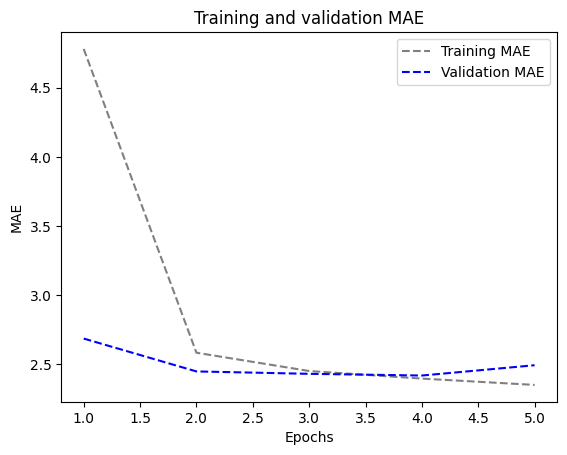

In [ ]:
import matplotlib.pyplot as plt
loss_of_LSTMS = history_of_LSTMS.history["mae"]
valid_loss_of_LSTMS = history_of_LSTMS.history["val_mae"]

epochs = range(1, len(loss_of_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_of_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_loss_of_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [ ]:
input_of_LSTMR = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
p5 = layers.LSTM(16, recurrent_dropout=0.25)(input_of_LSTMR )
p5 = layers.Dropout(0.5)(p5)
output_of_LSTMR = layers.Dense(1)(p5)
model_of_LSTMR = keras.Model(input_of_LSTMR , output_of_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_of_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_of_LSTMR = model_of_LSTMR.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 69s 82ms/step - loss: 50.2415 - mae: 5.2894 - val_loss: 13.8638 - val_mae: 2.7925
Epoch 2/5
819/819 [==============================] - 67s 81ms/step - loss: 20.0133 - mae: 3.4352 - val_loss: 10.1617 - val_mae: 2.4769
Epoch 3/5
819/819 [==============================] - 67s 82ms/step - loss: 18.1017 - mae: 3.2701 - val_loss: 9.6316 - val_mae: 2.4206
Epoch 4/5
819/819 [==============================] - 67s 82ms/step - loss: 17.2641 - mae: 3.1937 - val_loss: 9.4998 - val_mae: 2.4096
Epoch 5/5
819/819 [==============================] - 68s 83ms/step - loss: 16.6241 - mae: 3.1352 - val_loss: 9.2629 - val_mae: 2.3755


In [ ]:
model_of_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_of_LSTMR.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 9s 20ms/step - loss: 10.6516 - mae: 2.5685
Test MAE: 2.57


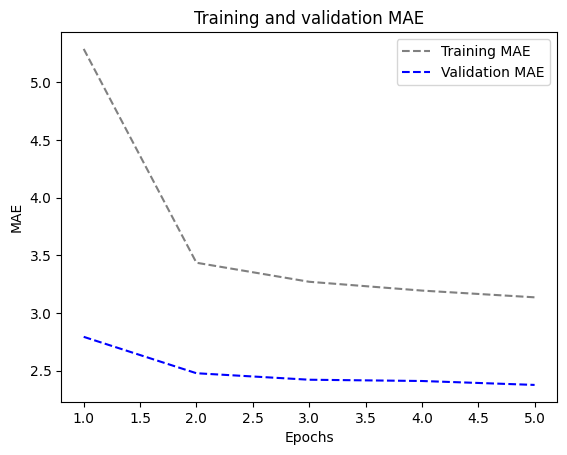

In [ ]:
import matplotlib.pyplot as plt
loss_of_LSTMR = history_of_LSTMR .history["mae"]
valid_loss_of_LSTMR = history_of_LSTMR .history["val_mae"]

epochs = range(1, len(loss_of_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_of_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_loss_of_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [ ]:
inputLSTM16 = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
P6 = layers.LSTM(16, return_sequences=True)(inputLSTM16)
P6 = layers.LSTM(16)(P6)
outputLSTM16 = layers.Dense(1)(P6)
modelLSTM16 = keras.Model(inputLSTM16, outputLSTM16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
modelLSTM16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
historyLSTM16 = modelLSTM16.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    callbacks=callbacks)


Epoch 1/5
819/819 [==============================] - 105s 124ms/step - loss: 39.2206 - mae: 4.5642 - val_loss: 12.2193 - val_mae: 2.6467
Epoch 2/5
819/819 [==============================] - 100s 122ms/step - loss: 10.1833 - mae: 2.4757 - val_loss: 9.8169 - val_mae: 2.4361
Epoch 3/5
819/819 [==============================] - 100s 122ms/step - loss: 8.8730 - mae: 2.3197 - val_loss: 9.3948 - val_mae: 2.3936
Epoch 4/5
819/819 [==============================] - 100s 122ms/step - loss: 8.2536 - mae: 2.2368 - val_loss: 9.7285 - val_mae: 2.4223
Epoch 5/5
819/819 [==============================] - 100s 122ms/step - loss: 7.7565 - mae: 2.1665 - val_loss: 9.8777 - val_mae: 2.4361


In [ ]:
modelLSTM16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {modelLSTM16.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 18s 42ms/step - loss: 10.7309 - mae: 2.5796
Test MAE: 2.58


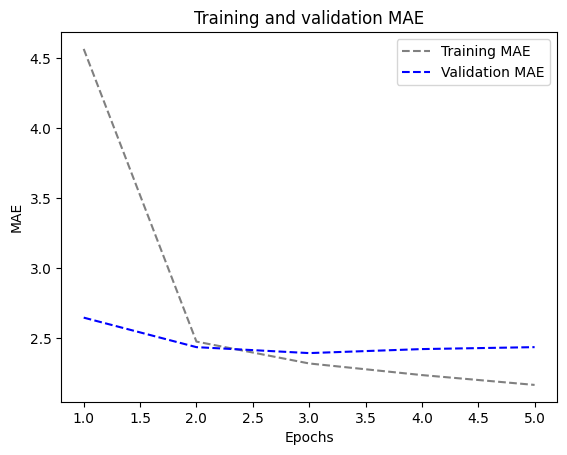

In [ ]:
import matplotlib.pyplot as plt
lossLSTM16 = historyLSTM16.history["mae"]
valid_lossLSTM16 = historyLSTM16.history["val_mae"]

epochs = range(1, len(lossLSTM16) + 1)
plt.figure()
plt.plot(epochs, lossLSTM16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_lossLSTM16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 32 units

In [ ]:
inputLSTM32 = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
P7 = layers.LSTM(32, return_sequences=True)(inputLSTM32)
P7 = layers.LSTM(32)(P7)
outputLSTM32 = layers.Dense(1)(P7)
modelLSTM32 = keras.Model(inputLSTM32, outputLSTM32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
modelLSTM32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
historyLSTM32 = modelLSTM32.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 143s 171ms/step - loss: 21.1462 - mae: 3.3024 - val_loss: 10.4629 - val_mae: 2.5302
Epoch 2/10
819/819 [==============================] - 137s 167ms/step - loss: 7.9837 - mae: 2.2009 - val_loss: 10.3779 - val_mae: 2.4968
Epoch 3/10
819/819 [==============================] - 136s 166ms/step - loss: 6.4029 - mae: 1.9657 - val_loss: 11.5918 - val_mae: 2.6447
Epoch 4/10
819/819 [==============================] - 137s 167ms/step - loss: 5.2679 - mae: 1.7833 - val_loss: 12.0607 - val_mae: 2.6918
Epoch 5/10
819/819 [==============================] - 136s 166ms/step - loss: 4.4774 - mae: 1.6395 - val_loss: 12.9051 - val_mae: 2.7766
Epoch 6/10
819/819 [==============================] - 137s 167ms/step - loss: 3.7989 - mae: 1.5113 - val_loss: 13.6792 - val_mae: 2.8408
Epoch 7/10
819/819 [==============================] - 136s 167ms/step - loss: 3.4332 - mae: 1.4311 - val_loss: 13.1491 - val_mae: 2.8061
Epoch 8/10
819/819 [====================

In [ ]:
modelLSTM32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {modelLSTM32.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 27s 65ms/step - loss: 12.6655 - mae: 2.7823
Test MAE: 2.78


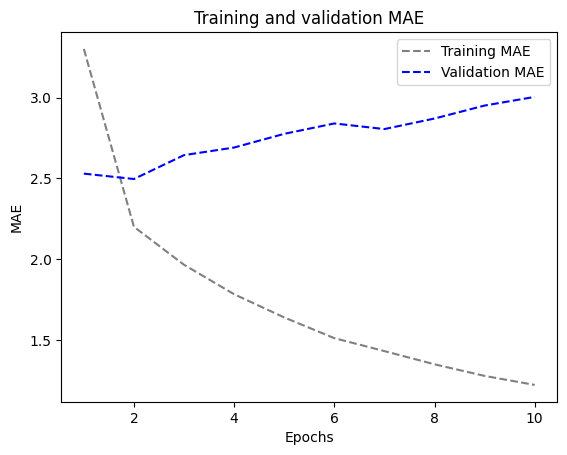

In [ ]:
import matplotlib.pyplot as plt
lossLSTM32 = historyLSTM32.history["mae"]
valid_lossLSTM32 = historyLSTM32.history["val_mae"]

epochs = range(1, len(lossLSTM32) + 1)
plt.figure()
plt.plot(epochs, lossLSTM32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_lossLSTM32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - Stacked setup with 8 units

In [ ]:
inputLSTM8u = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
P8 = layers.LSTM(8, return_sequences=True)(inputLSTM8u)
P8 = layers.LSTM(8)(P8)
outputLSTM8u = layers.Dense(1)(P8)
modelLSTM8u = keras.Model(inputLSTM8u, outputLSTM8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
modelLSTM8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
historyLSTM8u = modelLSTM8u.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 85s 100ms/step - loss: 80.2454 - mae: 6.9520 - val_loss: 42.7778 - val_mae: 4.9324
Epoch 2/10
819/819 [==============================] - 82s 100ms/step - loss: 25.6925 - mae: 3.7461 - val_loss: 14.5497 - val_mae: 2.8341
Epoch 3/10
819/819 [==============================] - 82s 100ms/step - loss: 11.9750 - mae: 2.6626 - val_loss: 9.7305 - val_mae: 2.4021
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 10.0962 - mae: 2.4672 - val_loss: 9.3855 - val_mae: 2.3734
Epoch 5/10
819/819 [==============================] - 81s 99ms/step - loss: 9.6367 - mae: 2.4144 - val_loss: 8.9896 - val_mae: 2.3240
Epoch 6/10
819/819 [==============================] - 81s 99ms/step - loss: 9.2700 - mae: 2.3716 - val_loss: 9.0936 - val_mae: 2.3458
Epoch 7/10
819/819 [==============================] - 82s 100ms/step - loss: 8.9490 - mae: 2.3342 - val_loss: 9.3756 - val_mae: 2.3723
Epoch 8/10
819/819 [==============================] 

In [ ]:
modelLSTM8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {modelLSTM8u.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.4746 - mae: 2.5401
Test MAE: 2.54


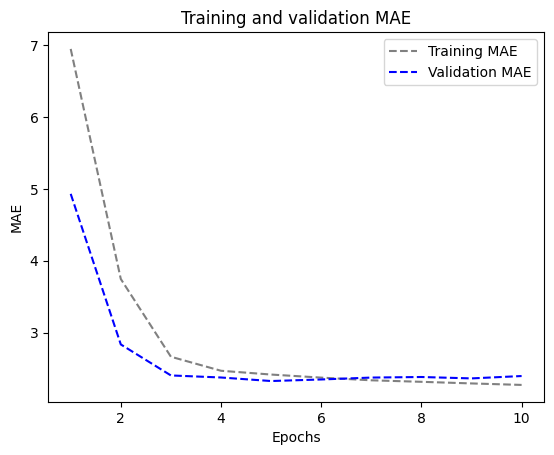

In [ ]:
import matplotlib.pyplot as plt
lossLSTM8u = historyLSTM8u.history["mae"]
valid_lossLSTM8u = historyLSTM8u.history["val_mae"]

epochs = range(1, len(lossLSTM8u) + 1)
plt.figure()
plt.plot(epochs, lossLSTM8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_lossLSTM8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6.LSTM - dropout-regularized, stacked model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
P9 = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
P9 = layers.LSTM(8, recurrent_dropout=0.5)(P9)
P9 = layers.Dropout(0.5)(P9)
outputs = layers.Dense(1)(P9)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 125s 147ms/step - loss: 77.1943 - mae: 6.7877 - val_loss: 38.6803 - val_mae: 4.6703
Epoch 2/10
819/819 [==============================] - 120s 147ms/step - loss: 33.0543 - mae: 4.2968 - val_loss: 14.5524 - val_mae: 2.8435
Epoch 3/10
819/819 [==============================] - 120s 147ms/step - loss: 24.6991 - mae: 3.7594 - val_loss: 11.3768 - val_mae: 2.5858
Epoch 4/10
819/819 [==============================] - 120s 147ms/step - loss: 22.5957 - mae: 3.6059 - val_loss: 10.5930 - val_mae: 2.5092
Epoch 5/10
819/819 [==============================] - 120s 147ms/step - loss: 21.1893 - mae: 3.4997 - val_loss: 10.4498 - val_mae: 2.5050
Epoch 6/10
819/819 [==============================] - 120s 147ms/step - loss: 20.1981 - mae: 3.4143 - val_loss: 10.3904 - val_mae: 2.5048
Epoch 7/10
819/819 [==============================] - 120s 147ms/step - loss: 19.5198 - mae: 3.3614 - val_loss: 10.1682 - val_mae: 2.4797
Epoch 8/10
819/819 [==============

In [ ]:
modelr = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {modelr.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.6004 - mae: 2.5455
Test MAE: 2.55


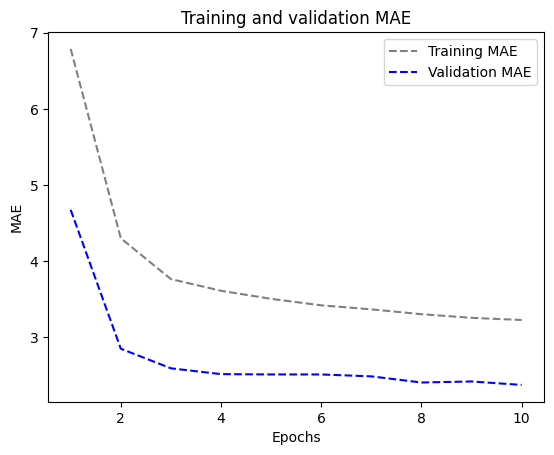

In [ ]:
import matplotlib.pyplot as plt
lossr = history.history["mae"]
valid_lossr = history.history["val_mae"]

epochs = range(1, len(lossr) + 1)
plt.figure()
plt.plot(epochs, lossr, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_lossr, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
o = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(o)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
historybi = model.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 61s 70ms/step - loss: 28.0336 - mae: 3.7970 - val_loss: 10.2217 - val_mae: 2.4797
Epoch 2/5
819/819 [==============================] - 57s 70ms/step - loss: 9.6663 - mae: 2.4232 - val_loss: 9.5837 - val_mae: 2.4025
Epoch 3/5
819/819 [==============================] - 57s 69ms/step - loss: 8.8197 - mae: 2.3116 - val_loss: 9.9631 - val_mae: 2.4330
Epoch 4/5
819/819 [==============================] - 57s 69ms/step - loss: 8.3083 - mae: 2.2422 - val_loss: 10.3441 - val_mae: 2.4712
Epoch 5/5
819/819 [==============================] - 57s 69ms/step - loss: 7.9217 - mae: 2.1911 - val_loss: 10.3294 - val_mae: 2.4837


In [ ]:
modelbi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {modelbi.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 11s 26ms/step - loss: 10.5198 - mae: 2.5438
Test MAE: 2.54


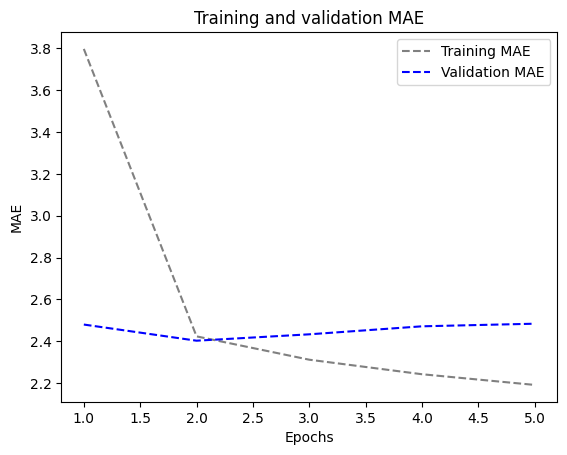

In [ ]:
import matplotlib.pyplot as plt
lossbi = historybi.history["mae"]
valid_lossbi = historybi.history["val_mae"]

epochs = range(1, len(lossbi) + 1)
plt.figure()
plt.plot(epochs, lossbi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_lossbi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [ ]:
input_last = keras.Input(shape=(sequencelength, rawdata.shape[-1]))
j = layers.Conv1D(64, 3, activation='relu')(input_last)
j = layers.MaxPooling1D(3)(j)
j = layers.Conv1D(128, 3, activation='relu')(j)
j = layers.GlobalMaxPooling1D()(j)
j = layers.Reshape((-1, 128))(j)  # Reshape the data to be 3D
j = layers.LSTM(16)(j)
output_last = layers.Dense(1)(j)
model_last = keras.Model(input_last, output_last)

model_last.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_last = model_last.fit(train_data, epochs=5, validation_data=valid_data, callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 20s 22ms/step - loss: 46.3711 - mae: 5.0766 - val_loss: 26.0816 - val_mae: 3.9349
Epoch 2/5
819/819 [==============================] - 17s 21ms/step - loss: 17.5493 - mae: 3.2333 - val_loss: 21.9023 - val_mae: 3.6812
Epoch 3/5
819/819 [==============================] - 17s 21ms/step - loss: 14.4987 - mae: 2.9494 - val_loss: 25.4183 - val_mae: 3.9664
Epoch 4/5
819/819 [==============================] - 17s 21ms/step - loss: 12.9657 - mae: 2.7801 - val_loss: 22.2000 - val_mae: 3.7146
Epoch 5/5
819/819 [==============================] - 17s 21ms/step - loss: 11.8399 - mae: 2.6492 - val_loss: 23.3435 - val_mae: 3.8072


In [ ]:
model_last = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_last.evaluate(test_data)[1]:.2f}")

405/405 [==============================] - 5s 10ms/step - loss: 23.1513 - mae: 3.8005
Test MAE: 3.80


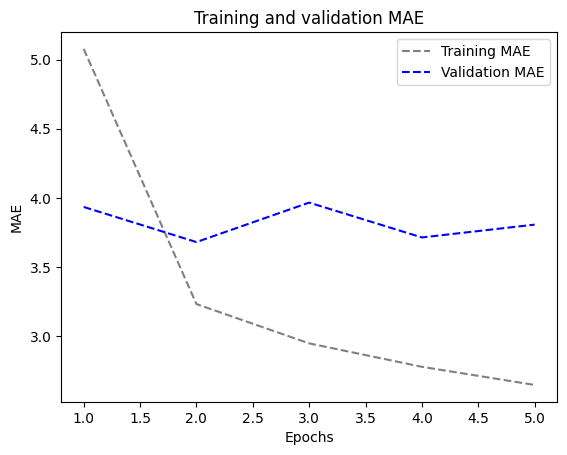

In [ ]:
import matplotlib.pyplot as plt
loss_last = history_last.history["mae"]
valid_loss_last = history_last.history["val_mae"]

epochs = range(1, len(loss_last) + 1)
plt.figure()
plt.plot(epochs, loss_last, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  valid_loss_last, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

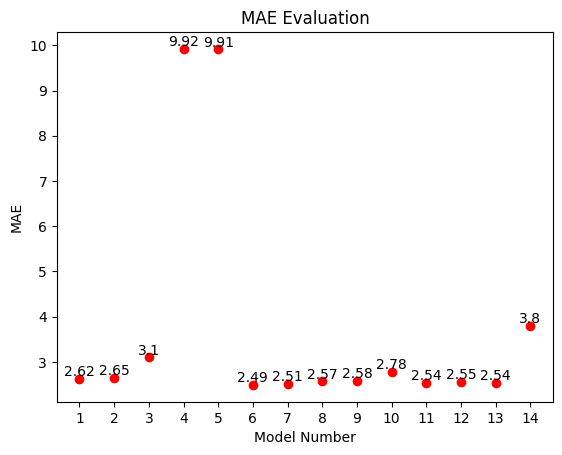

In [17]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.65,3.1,9.92,9.91,2.49,2.51,2.57,2.58,2.78,2.54,2.55,2.54,3.80)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

